# CNN with dropout

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [3]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [6]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [93]:
setup = cm.setup(glove_dir=GLOVE_DIR, embedding_dim=EMBEDDING_DIM)
(x_train, x_train_padded, y_train) = setup["train"]
(x_test, x_test_padded, y_test) = setup["test"]
word_index = setup["word_index"]

Found 400000 word vectors.
17361/88587 unknown words


In [10]:
# model version
model_version = "v1"

# descriptive model name
model_name = "cnn_%s" % model_version

# model save file
model_save_file = "./models/%s.h5" % model_name

# history save file
history_save_file = "./history/%s.csv" % model_name

# number of data points
N = x_train.shape[0]

# batch size for training
batch_size = 128

# training epochs 
epochs = 20

# validation split
validation_split = 0.05

# History

In [19]:
(history_df, last_epoch) = cm.load_history_from_file(history_save_file=history_save_file)

Last epoch: 20


In [17]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def create_model():
    model = tfk.Sequential([
        setup["embedding_layer"],
        tfkl.Dropout(0.25),
        tfkl.Conv1D(64, 15, activation="relu"),
        tfkl.Dropout(0.25),
        tfkl.Conv1D(64, 5, activation="relu"),
        tfkl.MaxPooling1D(10),
        tfkl.Dropout(0.25),
        tfkl.Flatten(),
        tfkl.Dropout(0.25),
        tfkl.Dense(64, activation='relu'),
        tfkl.Dropout(0.25),
        tfkl.Dense(1, activation='sigmoid')
    ], name=model_name)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=cmmetrics)
    return model

try:
    model = tfk.models.load_model(model_save_file)
    print("using saved model")
except IOError:
    model = create_model()
    print("model has not been trained (IOError)")
    
model.summary()

model has not been trained (IOError)
Model: "cnn_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2697, 50)          4429400   
_________________________________________________________________
dropout (Dropout)            (None, 2697, 50)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2683, 64)          48064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2683, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2679, 64)          20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 267, 64)           0         
_________________________________________________________________
dropout_2 (Dropout)    

In [18]:
model.fit(x_train_padded, 
          y_train, 
          validation_split=validation_split,
          initial_epoch=last_epoch,
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=cm.get_keras_callbacks(model_save_file=model_save_file, history_save_file=history_save_file))

W0620 19:02:56.650413 14724 deprecation.py:323] From C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 23750 samples, validate on 1250 samples
Epoch 1/20
23750/23750 [==============================] - 35s 1ms/sample - loss: 0.6508 - acc: 0.6059 - true_negatives: 7573.0000 - false_negatives: 5058.0000 - true_positives: 6818.0000 - false_positives: 4301.0000 - precision: 0.6132 - recall: 0.5741 - kl: 0.3318 - val_loss: 0.5555 - val_acc: 0.7152 - val_true_negatives: 373.0000 - val_false_negatives: 103.0000 - val_true_positives: 521.0000 - val_false_positives: 253.0000 - val_precision: 0.6731 - val_recall: 0.8349 - val_kl: 0.2252
Epoch 2/20
23750/23750 [==============================] - 32s 1ms/sample - loss: 0.5303 - acc: 0.7412 - true_negatives: 8818.0000 - false_negatives: 3090.0000 - true_positives: 8786.0000 - false_positives: 3056.0000 - precision: 0.7419 - recall: 0.7398 - kl: 0.2666 - val_loss: 0.5005 - val_acc: 0.7720 - val_true_negatives: 518.0000 - val_false_negatives: 177.0000 - val_true_positives: 447.0000 - val_false_positives: 108.0000 - val_precision: 0.8054 - val_r

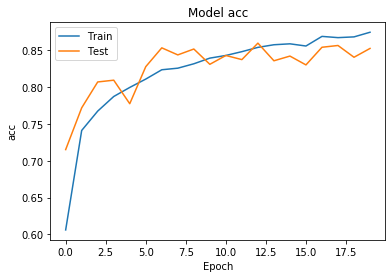

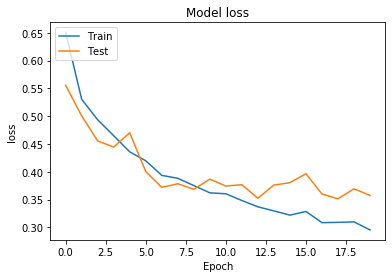

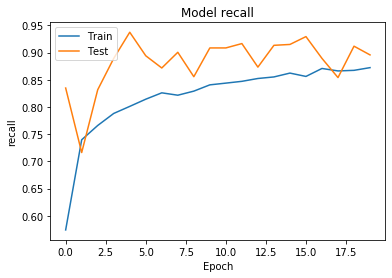

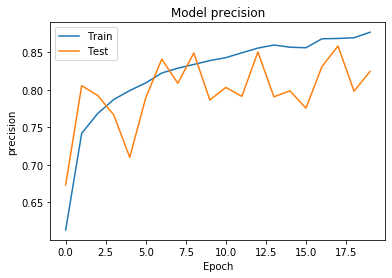

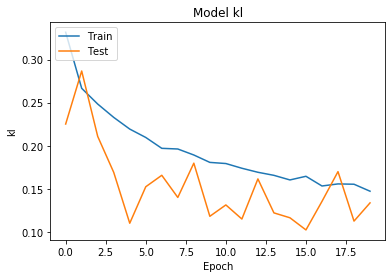

In [20]:
for metric in ["acc", "loss", "recall", "precision", "kl"] :
    cm.plot_metric(metric, history_df)
    plt.show()

In [21]:
def test_model(x, y):
    test_result = np.round(model.predict(x))
    test_errors = np.squeeze(test_result) != y
    correct_percentage = np.sum(test_errors) / len(y)
    print("%i / %i (%.2f%%) are correct" % (len(y) - np.sum(test_errors), len(y), 100 * (1 - correct_percentage)))

In [22]:
test_model(x_test_padded, y_test)
test_model(x_train_padded, y_train)

21081 / 25000 (84.32%) are correct
22913 / 25000 (91.65%) are correct


In [23]:
sentences = [
    "this was a very bad movie",
    "this was a very good movie",
    "I did not like this movie at all",
    "I hope there will be a sequal",
    "not bad",
    "bad",
    "not good",
    "one of the best movies of the year",
    "the first part was bad but the second part got better",
    "the first part was not bad but after that it just got worse",
    "this film was just brilliant casting location scenery story direction everyone's really suited part they played you could just imagine being there robert redford's is an amazing actor now same being director norman's father came from same scottish island as myself so i loved fact there was a real connection with this film witty remarks throughout film were great it was just brilliant so much that i bought"
]

rating = cm.Rating(word_index, model)
rating.print(rating.of(sentences))

 (2.75%)
this was a very bad movie

⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ (97.34%)
this was a very good movie

⭐⭐⭐⭐⭐⭐⭐ (67.56%)
I did not like this movie at all

⭐⭐⭐⭐⭐⭐⭐⭐ (75.96%)
I hope there will be a sequal

⭐⭐⭐⭐⭐ (45.72%)
not bad

⭐⭐⭐⭐⭐⭐⭐ (72.67%)
bad

⭐⭐⭐⭐⭐⭐⭐⭐ (79.87%)
not good

⭐⭐⭐⭐⭐⭐⭐⭐ (83.84%)
one of the best movies of the year

⭐⭐⭐ (28.77%)
the first part was bad but the second part got better

 (4.81%)
the first part was not bad but after that it just got worse

⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ (98.55%)
this film was just brilliant casting location scenery story direction everyone's really suited part they played you could just imagine being there robert redford's is an amazing actor now same being director norman's father came from same scottish island as myself so i loved fact there was a real connection with this film witty remarks throughout film were great it was just brilliant so much that i bought

